# Анализ эксперимента train_from_buffer

In [20]:
import matplotlib.pyplot as plt

from nn_laser_stabilizer.config.config import load_config
from nn_laser_stabilizer.paths import get_experiment_dir

EXPERIMENT_DIR_PATH = get_experiment_dir(
    experiment_name="train-from-pid-data", 
    experiment_date="2026-02-16", 
    experiment_time="15-56-00"
)

CONFIG_PATH = EXPERIMENT_DIR_PATH / "config.yaml"
config = load_config(CONFIG_PATH)
print(f"Эксперимент: {config.experiment_name}")

Эксперимент: train-from-pid-data


## Анализ процесса обучения

In [21]:
import json
import numpy as np
import pandas as pd


def parse_train_logs(file_path):
    rows = []
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            entry = json.loads(line)
            if entry.get("event") != "step":
                continue
            rows.append({
                'step': entry['step'],
                'loss_q1': entry.get('loss_q1', np.nan),
                'loss_q2': entry.get('loss_q2', np.nan),
                'actor_loss': entry.get('actor_loss', np.nan),
                'buffer_size': entry.get('buffer_size', np.nan),
                'alpha': entry.get('alpha', np.nan),
                'alpha_loss': entry.get('alpha_loss', np.nan),
                'time': entry.get('time', np.nan),
            })
    
    return pd.DataFrame(rows)

In [22]:
TRAIN_LOG_PATH = EXPERIMENT_DIR_PATH / config.training.log_file
loss_df = parse_train_logs(TRAIN_LOG_PATH)
print(f"Загружено {len(loss_df)} записей из логов обучения")
print(f"Диапазон шагов обучения: {loss_df['step'].min()} - {loss_df['step'].max()}")

Загружено 3353 записей из логов обучения
Диапазон шагов обучения: 1 - 3353


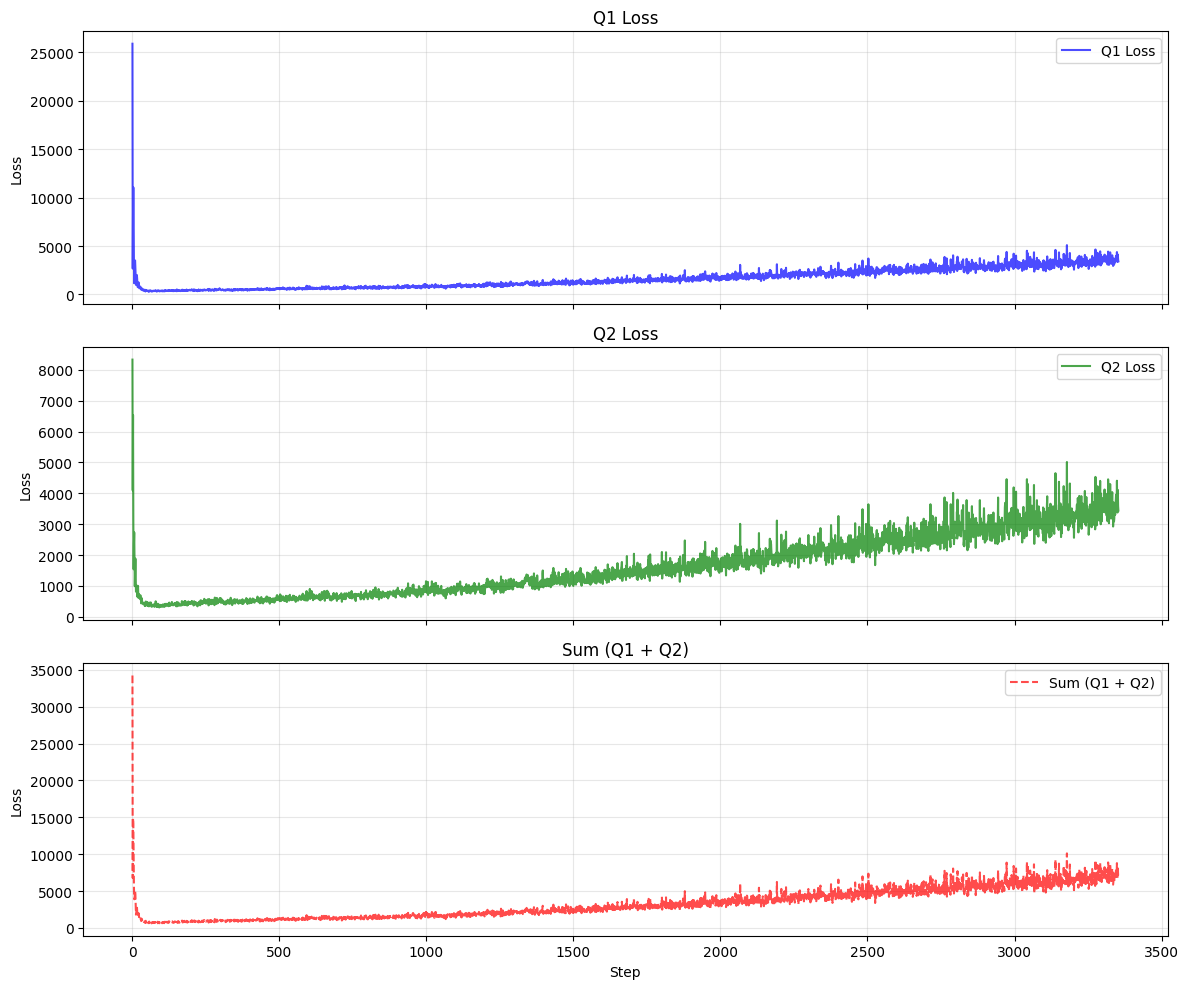

In [23]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

axes[0].plot(loss_df['step'], loss_df['loss_q1'], 'b-', alpha=0.7, label='Q1 Loss')
axes[0].set_title('Q1 Loss')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(loss_df['step'], loss_df['loss_q2'], 'g-', alpha=0.7, label='Q2 Loss')
axes[1].set_title('Q2 Loss')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(loss_df['step'], loss_df['loss_q1'] + loss_df['loss_q2'], 'r--', alpha=0.7, label='Sum (Q1 + Q2)')
axes[2].set_title('Sum (Q1 + Q2)')
axes[2].set_xlabel('Step')
axes[2].set_ylabel('Loss')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

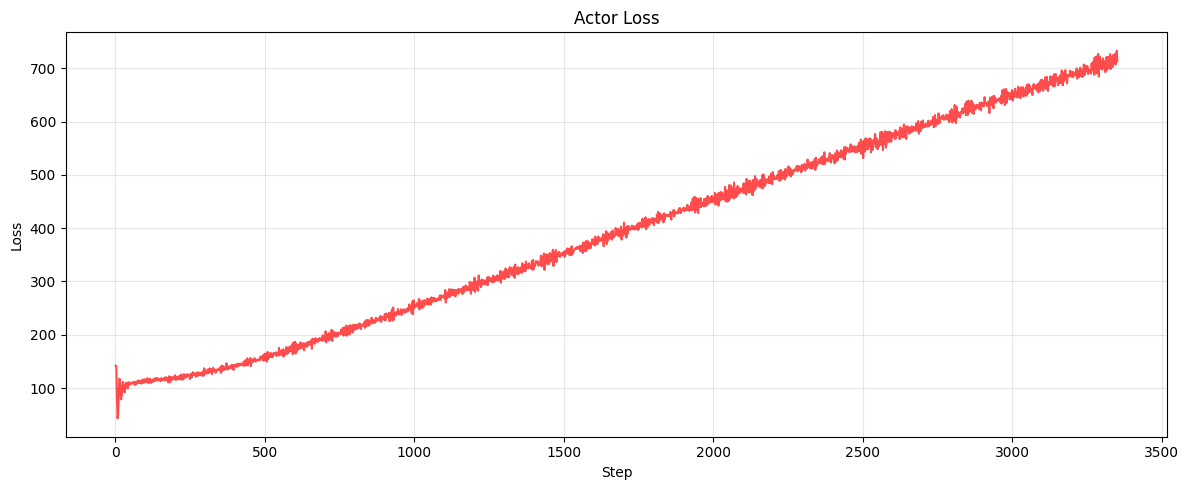

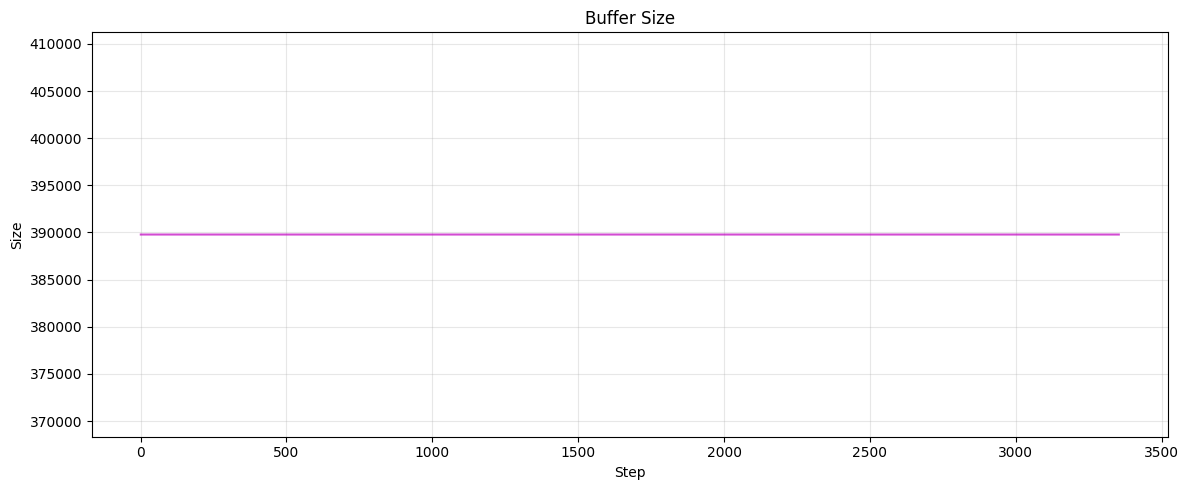

In [24]:
actor_loss_df = loss_df[loss_df['actor_loss'].notna()]

plt.figure(figsize=(12, 5))

plt.plot(actor_loss_df['step'], actor_loss_df['actor_loss'], 'r-', alpha=0.7)
plt.title('Actor Loss')

plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(loss_df['step'], loss_df['buffer_size'], 'm-', alpha=0.7)
plt.title('Buffer Size')
plt.xlabel('Step')
plt.ylabel('Size')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Анализ работы обученной модели

In [25]:
import torch

from nn_laser_stabilizer.rl.data.replay_buffer import ReplayBuffer
from nn_laser_stabilizer.rl.model.actor import load_actor_from_path
from nn_laser_stabilizer.config.types import NetworkType

ACTOR_PATH = EXPERIMENT_DIR_PATH / "models" / "actor.pth"  
BUFFER_PATH = EXPERIMENT_DIR_PATH / "data" / "replay_buffer.pth"

buffer = ReplayBuffer.load(BUFFER_PATH)
print(f"ReplayBuffer loaded. Size: {len(buffer)} / capacity={buffer.capacity}")

actor_path = ACTOR_PATH.resolve()
if not actor_path.exists():
    raise FileNotFoundError(f"Actor model not found: {actor_path}")

print(f"\nLoading actor from: {actor_path}")

network_type_str = config.algorithm.actor.network.type
network_type = NetworkType(network_type_str)

actor = load_actor_from_path(actor_path, network_type)
actor.eval()

print(f"Actor loaded successfully (type: {network_type_str})")

buffer_size = len(buffer)
observations = buffer.observations[:buffer_size]
true_actions = buffer.actions[:buffer_size]
rewards = buffer.rewards[:buffer_size]

ReplayBuffer loaded. Size: 389784 / capacity=389784

Loading actor from: C:\Users\artem\Workspace\Стабилизация лазера\nn-laser-stabilizer\experiments\2026-02-16_15-56-00_train-from-pid-data\models\actor.pth
Actor loaded successfully (type: mlp)


In [26]:
print(f"Analyzing {buffer_size} transitions...")

predicted_actions = []

with torch.no_grad():
    if network_type == NetworkType.LSTM:
        hidden_state = None
        for i in range(buffer_size):
            obs = observations[i]
            action, options = actor.act(obs, {'hidden_state': hidden_state})
            hidden_state = options.get('hidden_state')
            predicted_actions.append(action)
        
        predicted_actions = torch.stack(predicted_actions, dim=0)
    else:
        batch_size = 1024
        for i in range(0, buffer_size, batch_size):
            end_idx = min(i + batch_size, buffer_size)
            batch_obs = observations[i:end_idx]
            batch_actions, _ = actor.act(batch_obs)
            predicted_actions.append(batch_actions)
        
        predicted_actions = torch.cat(predicted_actions, dim=0)

print(f"Predictions completed. Shape: {predicted_actions.shape}")

Analyzing 389784 transitions...
Predictions completed. Shape: torch.Size([389784, 1])


Analysis Results:
Total transitions analyzed: 389784
Mean reward: -90.151878

Action prediction metrics:
  MSE (Mean Squared Error): 1.180325
  MAE (Mean Absolute Error): 1.000178


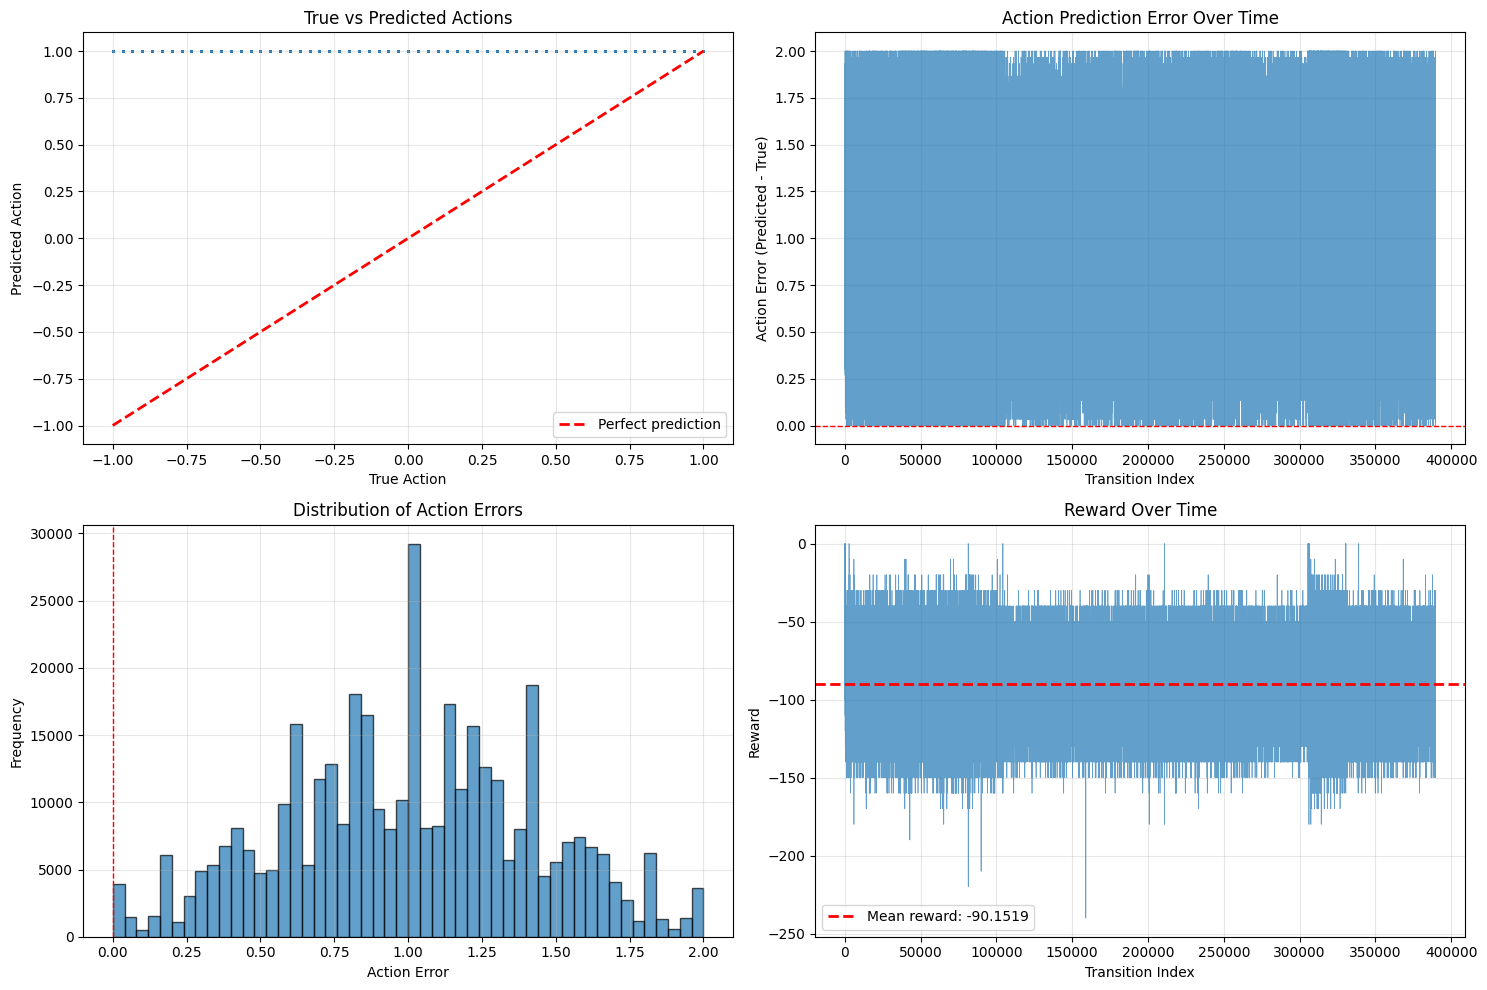

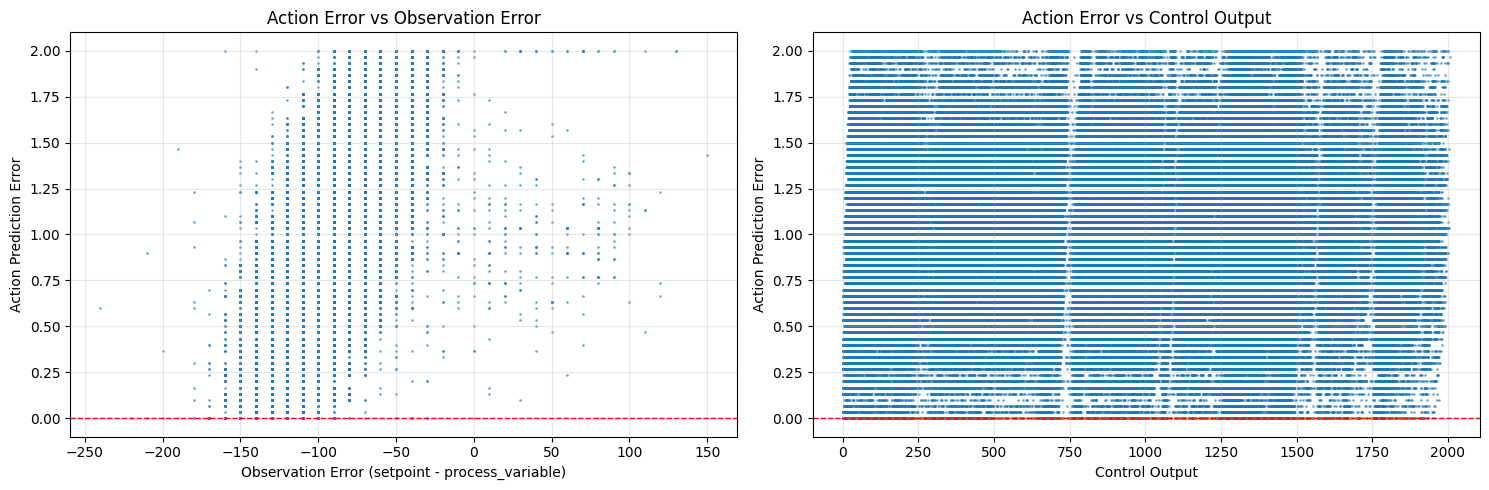

In [27]:
mse = torch.mean((predicted_actions - true_actions) ** 2).item()
mae = torch.mean(torch.abs(predicted_actions - true_actions)).item()

action_dim = true_actions.shape[1]
mse_per_dim = []
mae_per_dim = []
for dim in range(action_dim):
    mse_dim = torch.mean((predicted_actions[:, dim] - true_actions[:, dim]) ** 2).item()
    mae_dim = torch.mean(torch.abs(predicted_actions[:, dim] - true_actions[:, dim])).item()
    mse_per_dim.append(mse_dim)
    mae_per_dim.append(mae_dim)

mean_reward = torch.mean(rewards).item()

print("=" * 60)
print("Analysis Results:")
print("=" * 60)
print(f"Total transitions analyzed: {buffer_size}")
print(f"Mean reward: {mean_reward:.6f}")
print("")
print("Action prediction metrics:")
print(f"  MSE (Mean Squared Error): {mse:.6f}")
print(f"  MAE (Mean Absolute Error): {mae:.6f}")

if action_dim > 1:
    print("  Per-dimension metrics:")
    for dim in range(action_dim):
        print(f"    Dim {dim}: MSE={mse_per_dim[dim]:.6f}, MAE={mae_per_dim[dim]:.6f}")

print("=" * 60)

obs_error = observations[:, 0].numpy()
obs_control_output = observations[:, 3].numpy()
true_actions_np = true_actions[:, 0].numpy()
predicted_actions_np = predicted_actions[:, 0].numpy()
rewards_np = rewards[:, 0].numpy()
action_errors = predicted_actions_np - true_actions_np

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].scatter(true_actions_np, predicted_actions_np, alpha=0.5, s=1)
axes[0, 0].plot([true_actions_np.min(), true_actions_np.max()], 
                [true_actions_np.min(), true_actions_np.max()], 
                'r--', lw=2, label='Perfect prediction')
axes[0, 0].set_xlabel('True Action')
axes[0, 0].set_ylabel('Predicted Action')
axes[0, 0].set_title('True vs Predicted Actions')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(action_errors, alpha=0.7, linewidth=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=1)
axes[0, 1].set_xlabel('Transition Index')
axes[0, 1].set_ylabel('Action Error (Predicted - True)')
axes[0, 1].set_title('Action Prediction Error Over Time')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(action_errors, bins=50, alpha=0.7, edgecolor='black')
axes[1, 0].axvline(x=0, color='r', linestyle='--', linewidth=1)
axes[1, 0].set_xlabel('Action Error')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Action Errors')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(rewards_np, alpha=0.7, linewidth=0.5)
axes[1, 1].axhline(y=mean_reward, color='r', linestyle='--', linewidth=2, 
                   label=f'Mean reward: {mean_reward:.4f}')
axes[1, 1].set_xlabel('Transition Index')
axes[1, 1].set_ylabel('Reward')
axes[1, 1].set_title('Reward Over Time')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].scatter(obs_error, action_errors, alpha=0.5, s=1)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=1)
axes[0].set_xlabel('Observation Error (setpoint - process_variable)')
axes[0].set_ylabel('Action Prediction Error')
axes[0].set_title('Action Error vs Observation Error')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(obs_control_output, action_errors, alpha=0.5, s=1)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=1)
axes[1].set_xlabel('Control Output')
axes[1].set_ylabel('Action Prediction Error')
axes[1].set_title('Action Error vs Control Output')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

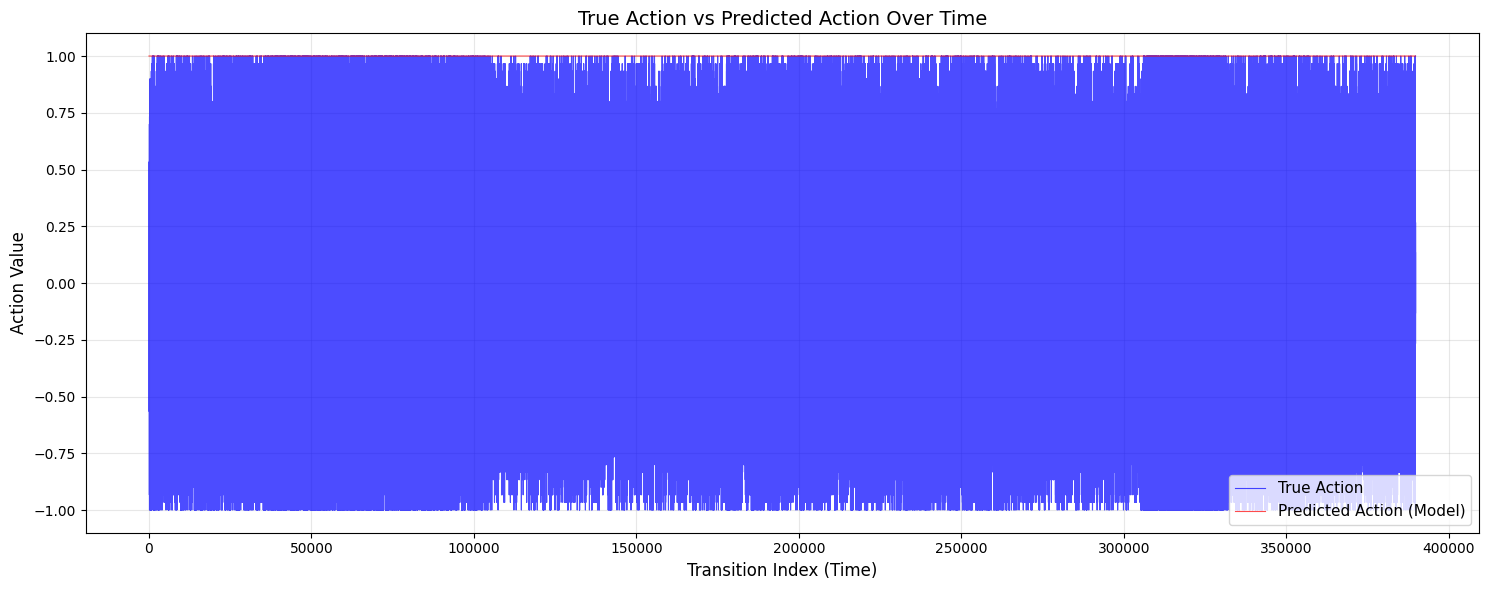

In [28]:
fig, ax = plt.subplots(figsize=(15, 6))

sample_size = len(true_actions_np) 
indices = np.arange(sample_size)

ax.plot(indices, true_actions_np[:sample_size], 
        label='True Action', 
        alpha=0.7, 
        linewidth=0.8,
        color='blue')

ax.plot(indices, predicted_actions_np[:sample_size], 
        label='Predicted Action (Model)', 
        alpha=0.7, 
        linewidth=0.8,
        color='red')

ax.set_xlabel('Transition Index (Time)', fontsize=12)
ax.set_ylabel('Action Value', fontsize=12)
ax.set_title('True Action vs Predicted Action Over Time', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

fig.tight_layout()


DataFrame head:


,error,error_prev,error_prev_prev,control_output,action,reward
0,60.0,70.0,70.0,2000.0,0.100000,-60.0
1,60.0,60.0,70.0,2003.0,-0.033333,-60.0
2,60.0,60.0,60.0,2002.0,-0.033333,-60.0
3,60.0,60.0,60.0,2001.0,-0.033333,-70.0
4,70.0,60.0,60.0,2000.0,-0.166667,-60.0



DataFrame describe:


,error,error_prev,error_prev_prev,control_output,action,reward
count,389784.000000,389784.000000,389784.000000,389784.000000,389784.000000,389784.000000
mean,-90.091293,-90.090843,-90.090439,909.195007,-0.000177,-90.151878
std,21.133184,21.134733,21.136290,534.038940,0.424229,20.873339
min,-240.000000,-240.000000,-240.000000,0.000000,-1.000000,-240.000000
25%,-100.000000,-100.000000,-100.000000,464.000000,-0.300000,-100.000000
50%,-90.000000,-90.000000,-90.000000,968.000000,0.000000,-90.000000
75%,-80.000000,-80.000000,-80.000000,1322.000000,0.300000,-80.000000
max,150.000000,150.000000,150.000000,2006.000000,1.000000,-0.000000


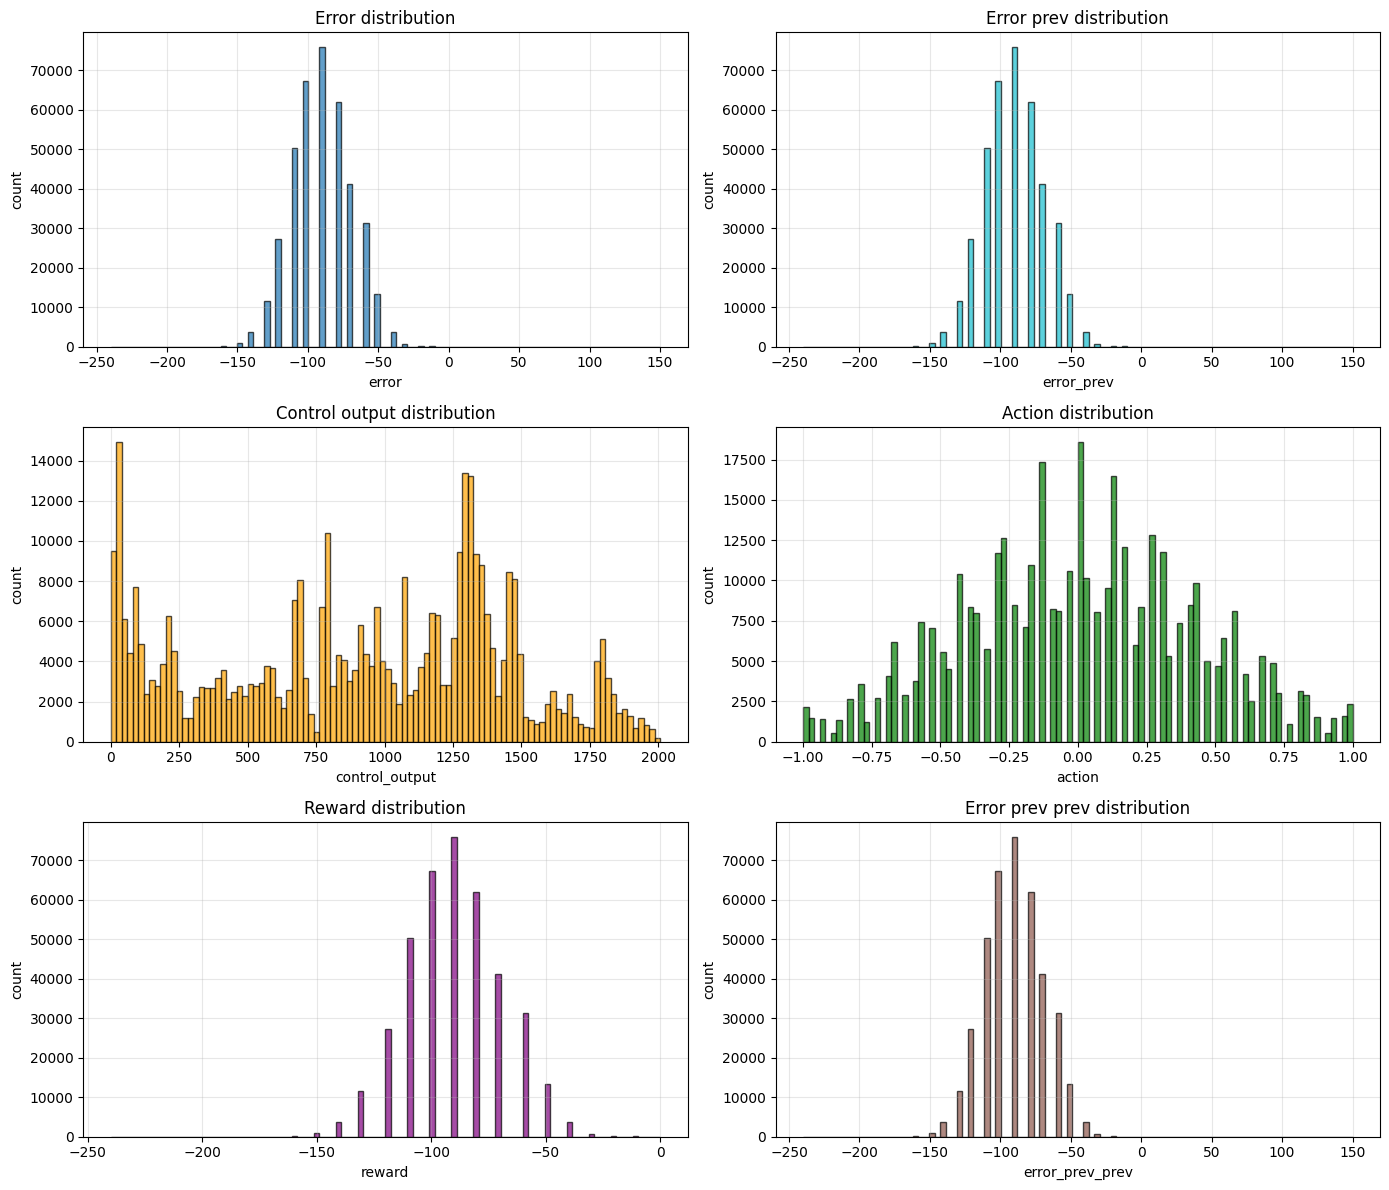

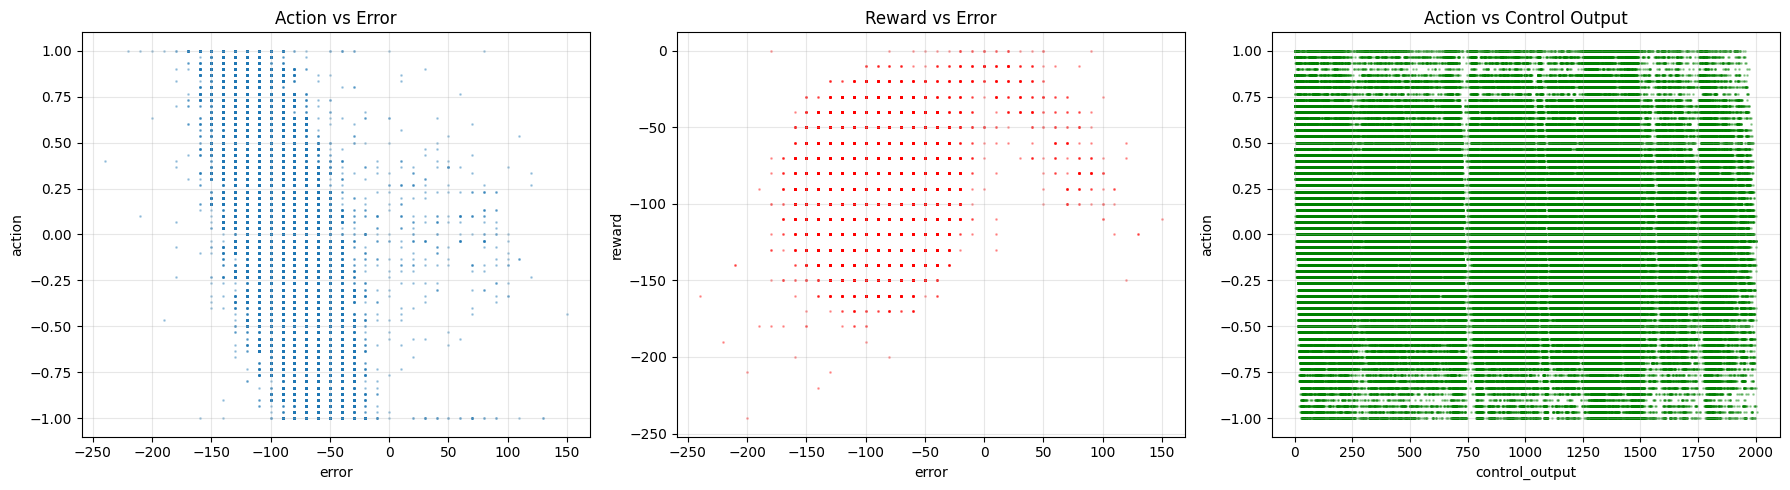

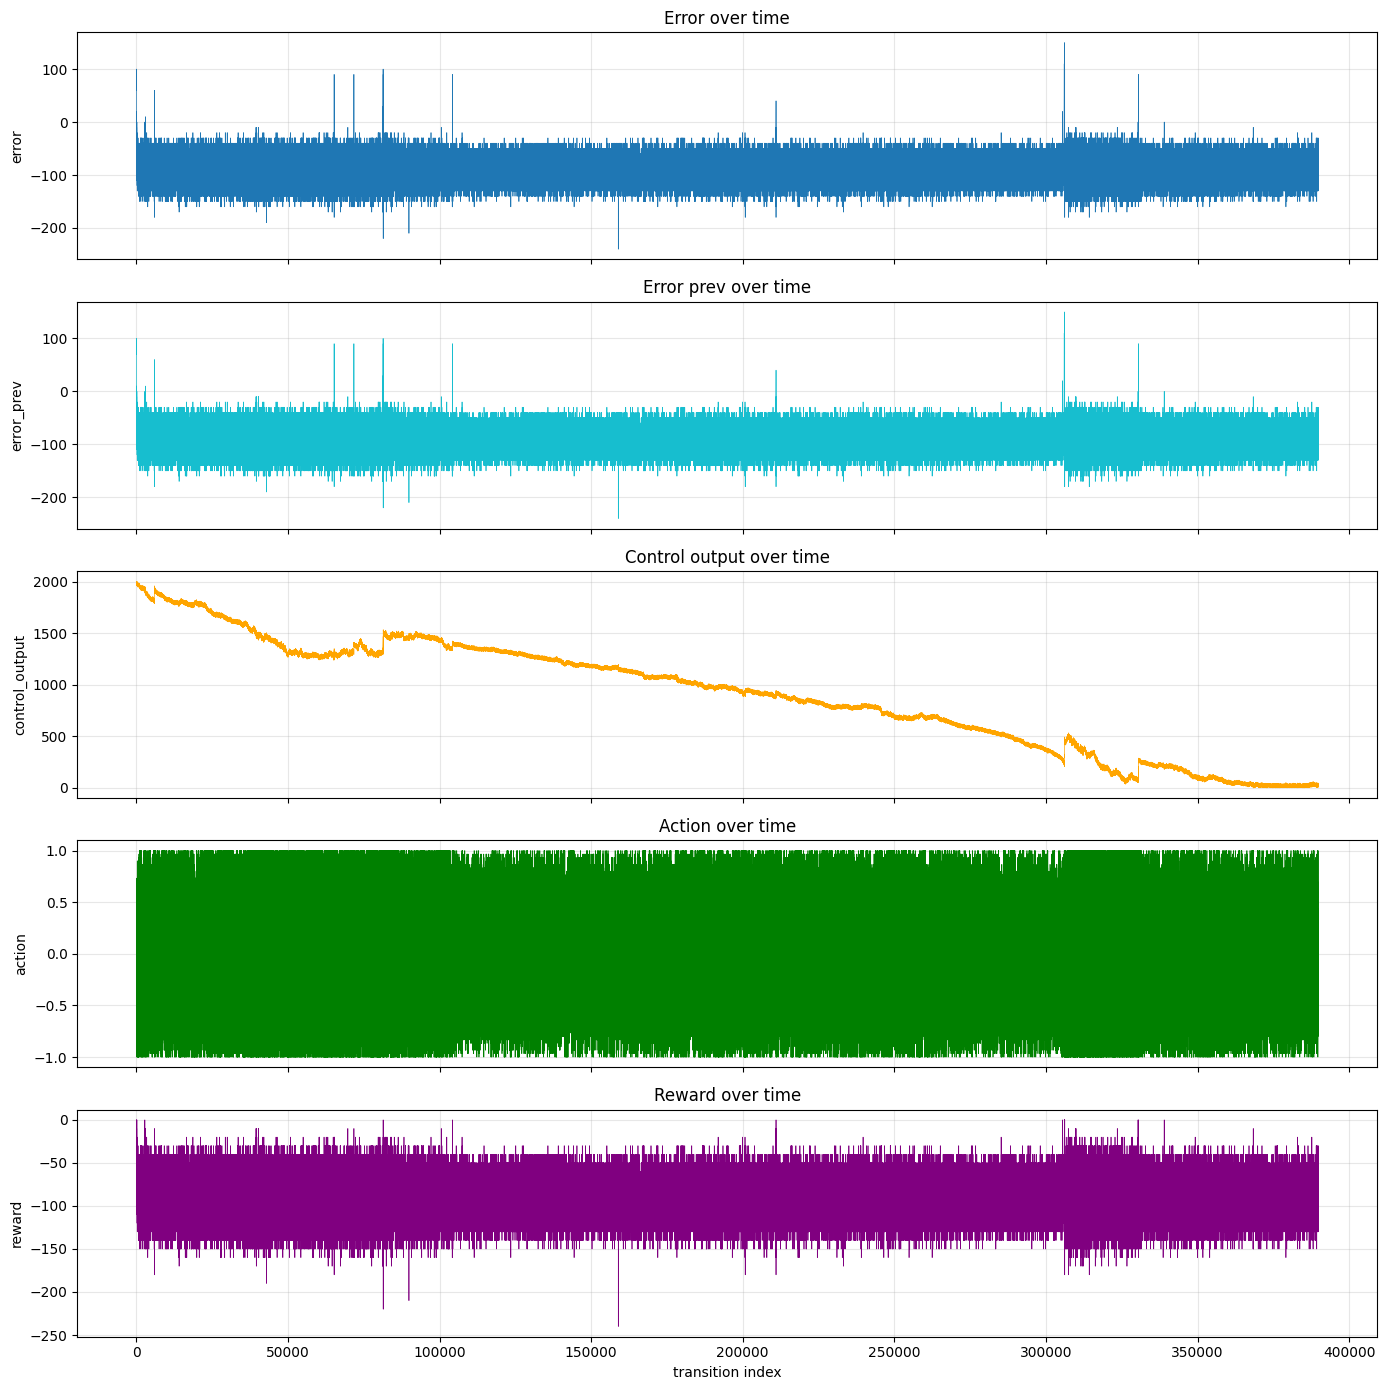

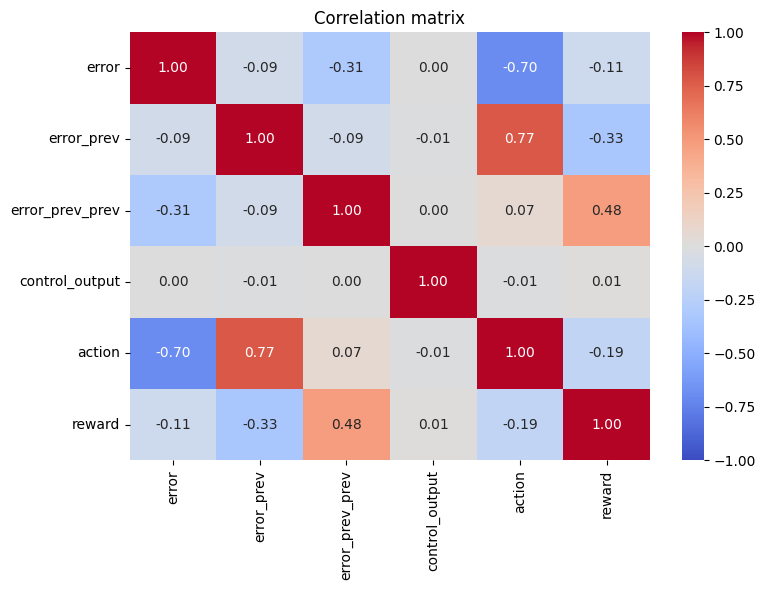

In [29]:
import seaborn as sns

observations = buffer.observations[:buffer_size]   # shape: [N, obs_dim]
actions      = buffer.actions[:buffer_size]        # shape: [N, act_dim]
rewards      = buffer.rewards[:buffer_size]        # shape: [N, 1]

# observation = [error, error_prev, error_prev_prev, control_output]
obs_error           = observations[:, 0].numpy()
obs_error_prev      = observations[:, 1].numpy()
obs_error_prev_prev = observations[:, 2].numpy()
obs_control_output  = observations[:, 3].numpy()
actions_np          = actions[:, 0].numpy()
rewards_np          = rewards[:, 0].numpy()

df = pd.DataFrame({
    "error": obs_error,
    "error_prev": obs_error_prev,
    "error_prev_prev": obs_error_prev_prev,
    "control_output": obs_control_output,
    "action": actions_np,
    "reward": rewards_np,
})
print("\nDataFrame head:")
display(df.head())
print("\nDataFrame describe:")
display(df.describe())

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

axes[0, 0].hist(df["error"], bins=100, alpha=0.7, edgecolor="black")
axes[0, 0].set_title("Error distribution")
axes[0, 0].set_xlabel("error")
axes[0, 0].set_ylabel("count")
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(df["error_prev"], bins=100, alpha=0.7, edgecolor="black", color="tab:cyan")
axes[0, 1].set_title("Error prev distribution")
axes[0, 1].set_xlabel("error_prev")
axes[0, 1].set_ylabel("count")
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(df["control_output"], bins=100, alpha=0.7, edgecolor="black", color="orange")
axes[1, 0].set_title("Control output distribution")
axes[1, 0].set_xlabel("control_output")
axes[1, 0].set_ylabel("count")
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(df["action"], bins=100, alpha=0.7, edgecolor="black", color="green")
axes[1, 1].set_title("Action distribution")
axes[1, 1].set_xlabel("action")
axes[1, 1].set_ylabel("count")
axes[1, 1].grid(True, alpha=0.3)

axes[2, 0].hist(df["reward"], bins=100, alpha=0.7, edgecolor="black", color="purple")
axes[2, 0].set_title("Reward distribution")
axes[2, 0].set_xlabel("reward")
axes[2, 0].set_ylabel("count")
axes[2, 0].grid(True, alpha=0.3)

axes[2, 1].hist(df["error_prev_prev"], bins=100, alpha=0.7, edgecolor="black", color="tab:brown")
axes[2, 1].set_title("Error prev prev distribution")
axes[2, 1].set_xlabel("error_prev_prev")
axes[2, 1].set_ylabel("count")
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(df["error"], df["action"], s=1, alpha=0.3)
axes[0].set_xlabel("error")
axes[0].set_ylabel("action")
axes[0].set_title("Action vs Error")
axes[0].grid(True, alpha=0.3)

axes[1].scatter(df["error"], df["reward"], s=1, alpha=0.3, color="red")
axes[1].set_xlabel("error")
axes[1].set_ylabel("reward")
axes[1].set_title("Reward vs Error")
axes[1].grid(True, alpha=0.3)

axes[2].scatter(df["control_output"], df["action"], s=1, alpha=0.3, color="green")
axes[2].set_xlabel("control_output")
axes[2].set_ylabel("action")
axes[2].set_title("Action vs Control Output")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

max_points = buffer_size
idx = np.arange(max_points)

fig, axes = plt.subplots(5, 1, figsize=(14, 14), sharex=True)

axes[0].plot(idx, df["error"].values[:max_points], linewidth=0.5)
axes[0].set_ylabel("error")
axes[0].set_title("Error over time")
axes[0].grid(True, alpha=0.3)

axes[1].plot(idx, df["error_prev"].values[:max_points], linewidth=0.5, color="tab:cyan")
axes[1].set_ylabel("error_prev")
axes[1].set_title("Error prev over time")
axes[1].grid(True, alpha=0.3)

axes[2].plot(idx, df["control_output"].values[:max_points], linewidth=0.5, color="orange")
axes[2].set_ylabel("control_output")
axes[2].set_title("Control output over time")
axes[2].grid(True, alpha=0.3)

axes[3].plot(idx, df["action"].values[:max_points], linewidth=0.5, color="green")
axes[3].set_ylabel("action")
axes[3].set_title("Action over time")
axes[3].grid(True, alpha=0.3)

axes[4].plot(idx, df["reward"].values[:max_points], linewidth=0.5, color="purple")
axes[4].set_ylabel("reward")
axes[4].set_xlabel("transition index")
axes[4].set_title("Reward over time")
axes[4].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()